# MGI vs Nanopore

Compare the taxa found using different sequencing technologies.

We have three different sequencing technologies, MGI short read (300 bp paired end reads), ONT MinION, and ONT PromethION. Here, we compare the different sequencing technologies to see which taxa we find.

This notebook makes Fig. S1.

In [1]:
# load the libaries
import os
import sys
from socket import gethostname

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib

datadir = '..'

In [2]:

def sorted_presence_absence(df1, df2, df3, minrowsum=0, asc_sort=False):
    """
    Join the two tables and return the sorted version
    """
    # filter so we only include samples sequenced on both MGI and MinION
    common_columns = df1.columns.intersection(df2.columns).intersection(df3.columns)
    df1_both = df1[common_columns]
    df2_both = df2[common_columns]
    df3_both = df3[common_columns]
    
    # create a presence/absence matrix
    df1_presence = (df1_both > 0).astype(int)
    df2_presence = (df2_both > 0).astype(int)*2
    df3_presence = (df3_both > 0).astype(int)*4
    
    # here we filter on the minimum number of columns each taxa is in if requested
    if minrowsum > 0:
        df1_presence = df1_presence.loc[df1_presence[df1_presence.sum(axis=1) > minrowsum].index]
        df2_presence = df2_presence.loc[df2_presence[df2_presence.sum(axis=1) > (2 * minrowsum)].index]
        df3_presence = df3_presence.loc[df3_presence[df3_presence.sum(axis=1) > (4 * minrowsum)].index]
    
    # combine the  matrices and sort them
    both = df1_presence.add(df2_presence, fill_value=0).add(df3_presence, fill_value=0)
    sboth = both.loc[both.sum(axis=1).sort_values(ascending=asc_sort).index]
    sboth = sboth.sort_index(axis=1) # sort by column names

    return sboth

def convert_df_xyz(mgi_df, sboth):
    """
    Convert the data frame into xyz values. X and Y come from `sboth` (sorted both MGI & Minion) and Z comes from MGI coverage.
    """
   
    # we need to get the MGI data in the same order as the sboth dataframe
    mgi_reorg = mgi_df.reindex(index=sboth.index, columns=sboth.columns)

    # Prepare data for 3D plot
    x = np.arange(sboth.shape[1])  # x coordinates (samples)
    y = np.arange(sboth.shape[0])  # y coordinates (taxa)
    x, y = np.meshgrid(x, y)  # Create a meshgrid for x and y
    z = mgi_reorg.values  # Height values

    return (x, y, z)

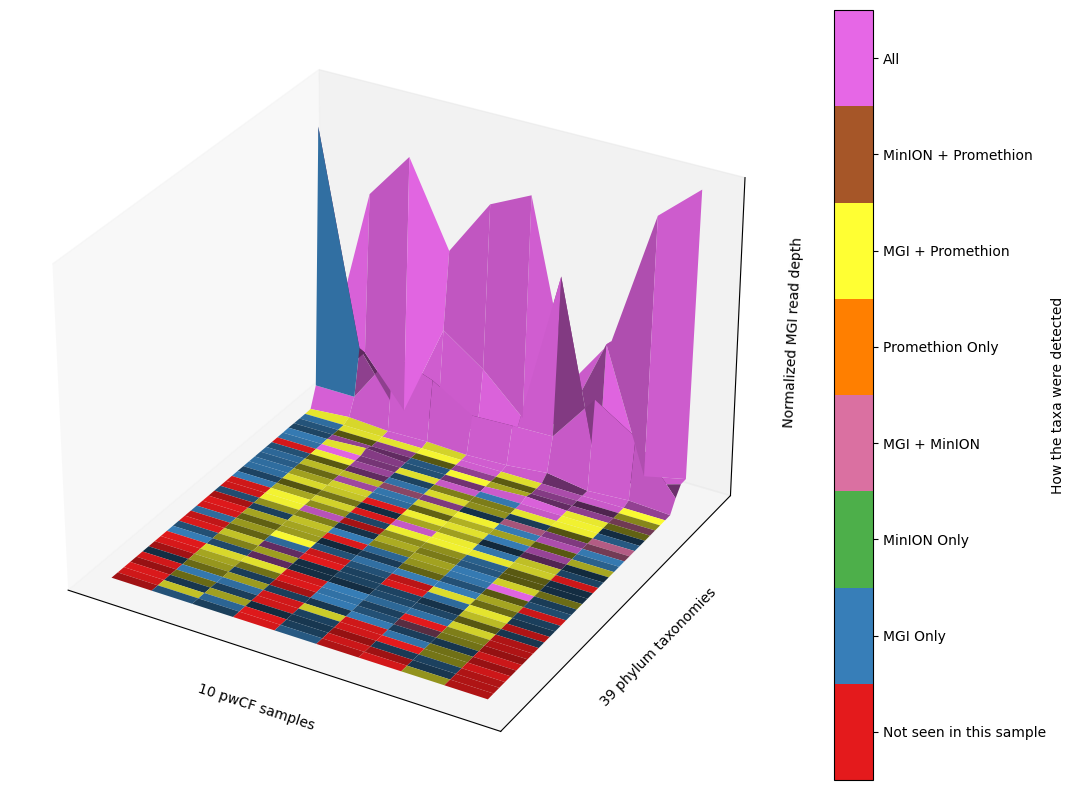

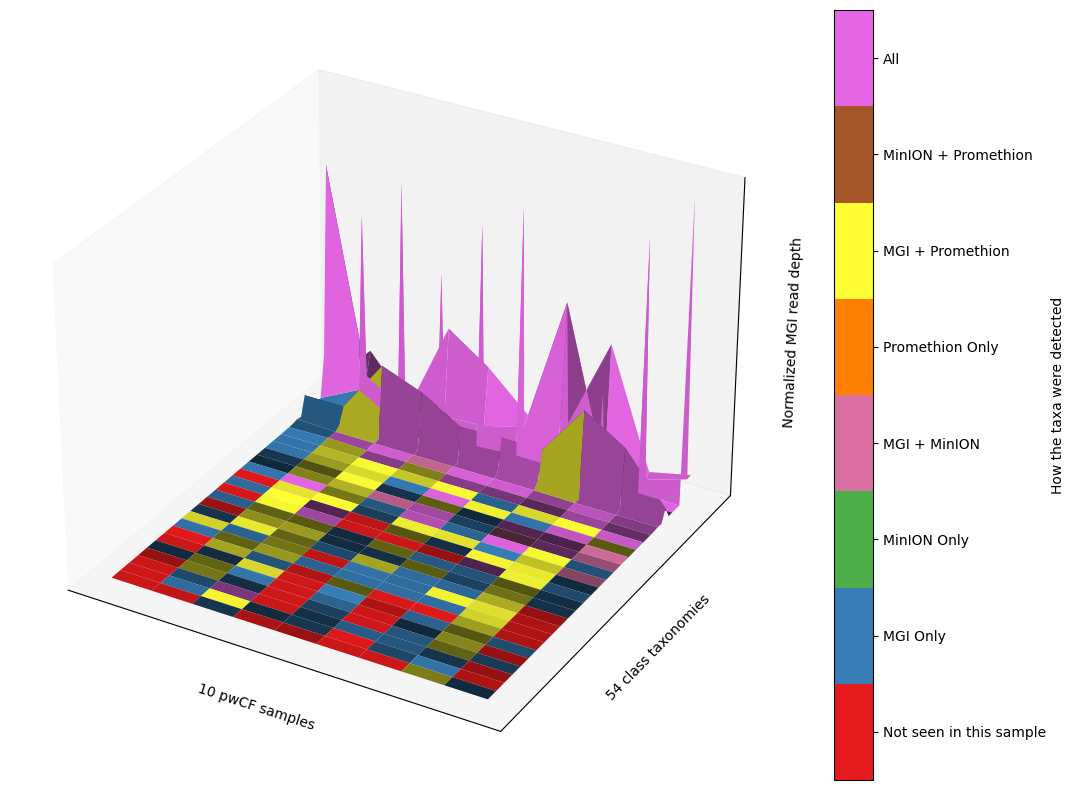

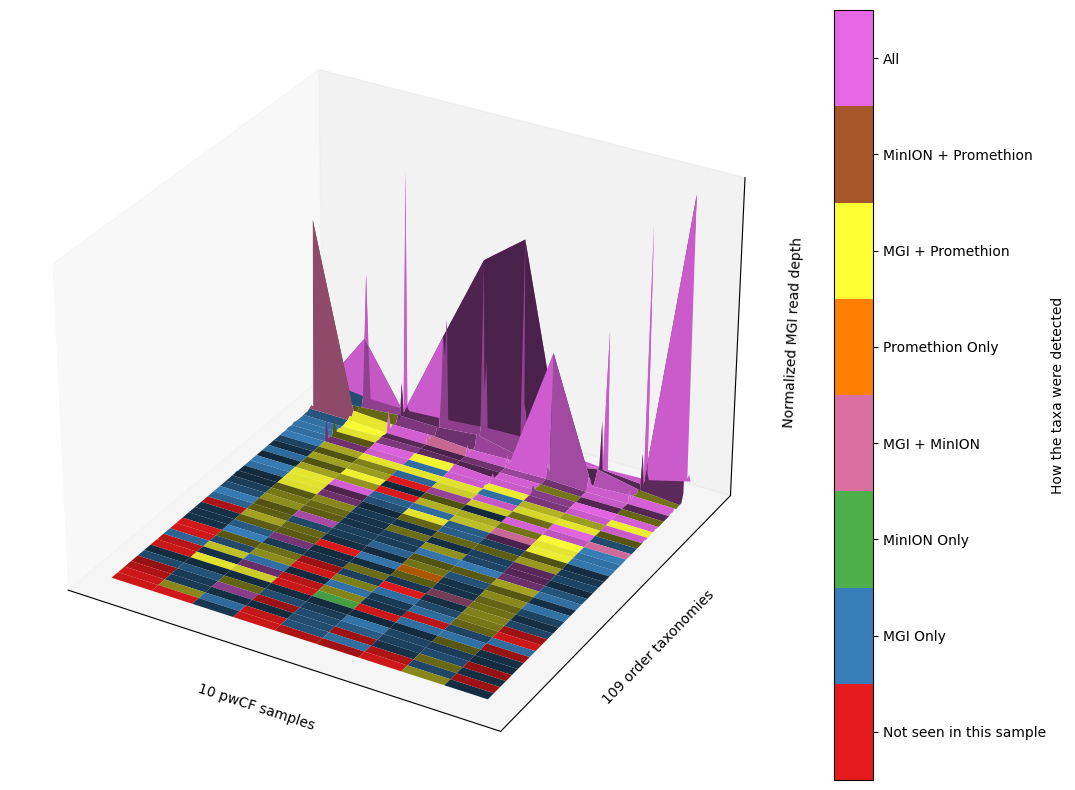

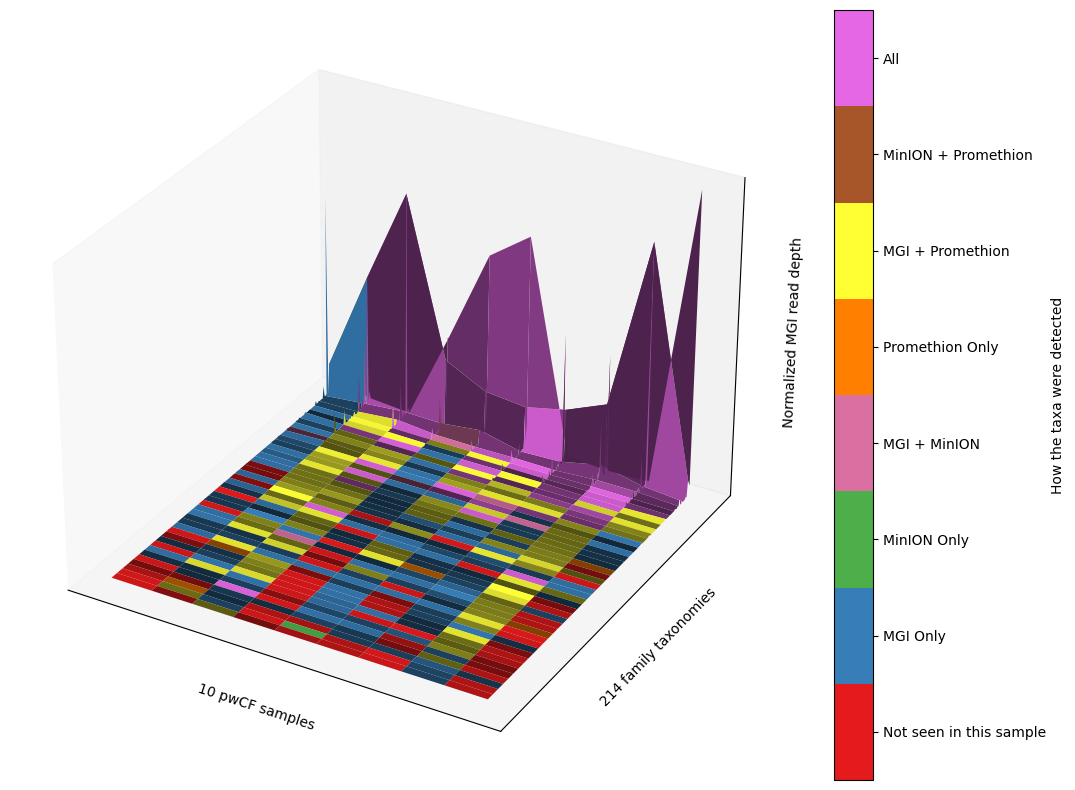

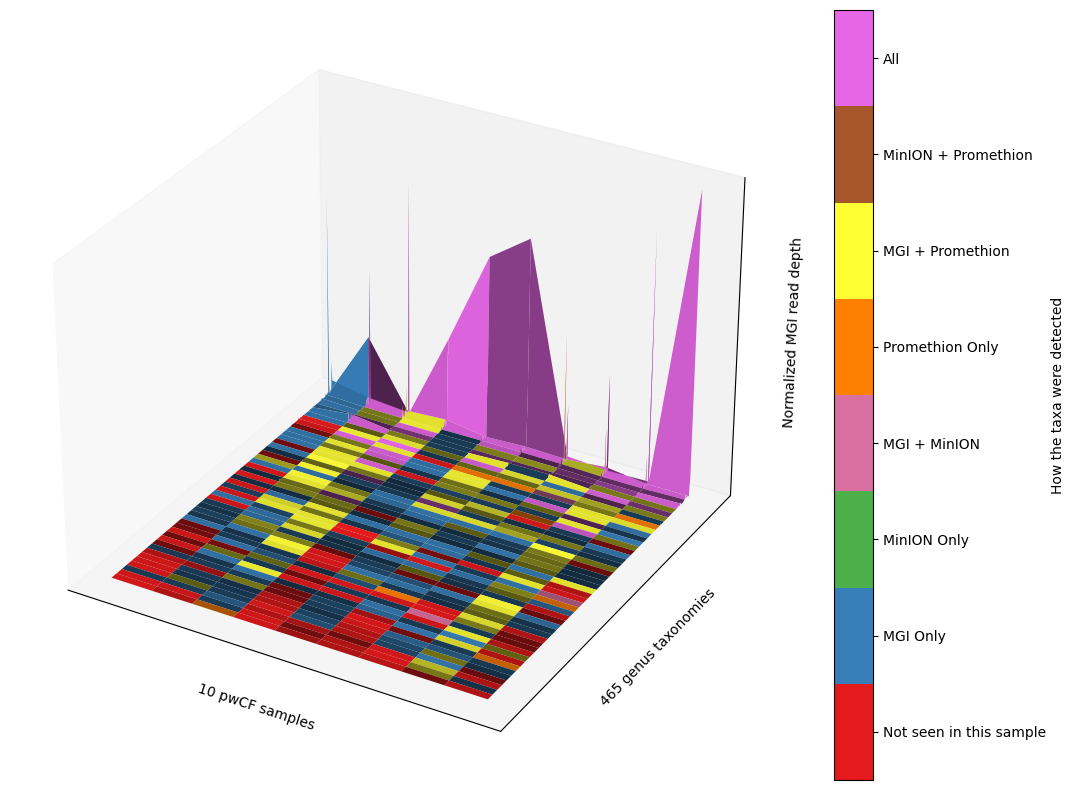

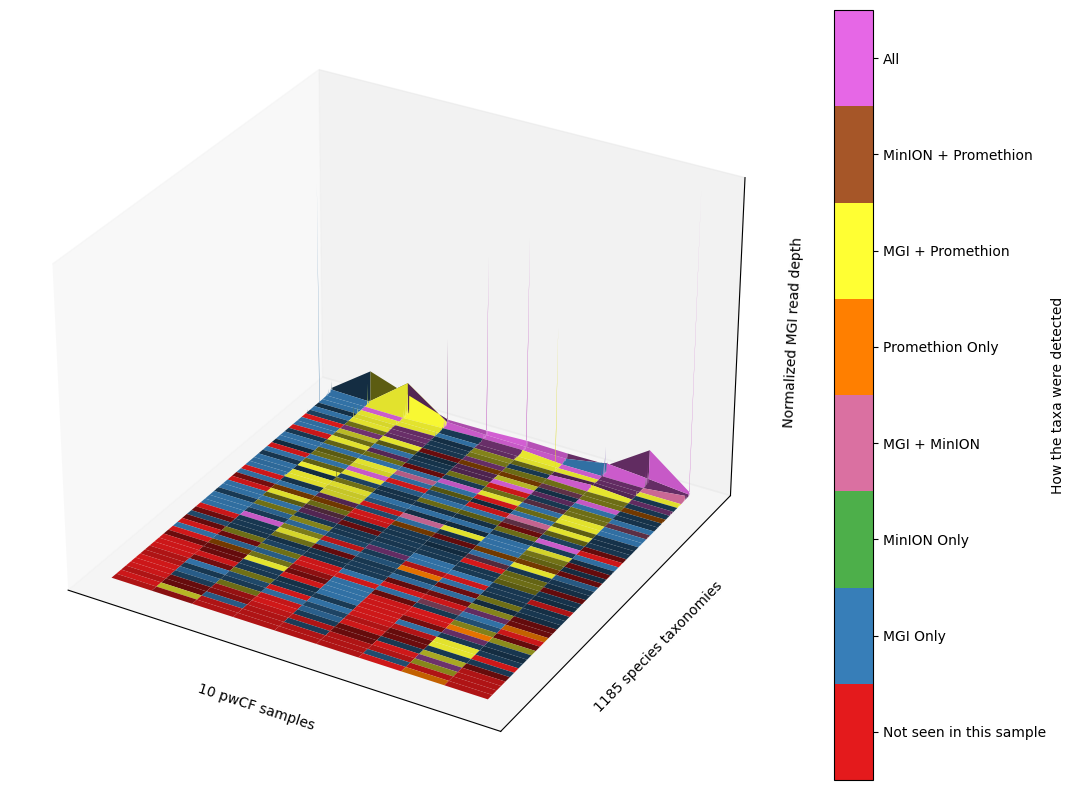

a. 39 phylum taxonomies and RPKM ranges up to 811,485; b. 54 class taxonomies and RPKM ranges up to 781,208; c. 109 order taxonomies and RPKM ranges up to 694,463; d. 214 family taxonomies and RPKM ranges up to 636,830; e. 465 genus taxonomies and RPKM ranges up to 597,643; f. 1185 species taxonomies and RPKM ranges up to 388,863; 


In [3]:
taxonomies = ['phylum', 'class', 'order', 'family', 'genus', 'species']

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#da70a1', '#ff7f00', '#ffff33', '#a65628', '#e667e6']
cmap = ListedColormap(colors)
# palette = sns.color_palette("tab10_r", 8)
# cmap = ListedColormap(palette)


row = 0
col = 0
minreads = 10
subsc = "abcdefgh"
legenedtext = ""

# read_taxonomy(datadir, sequence_type, taxonomy, all_taxa=False, rawdata=False):
for i, tax in enumerate(taxonomies):
    mgi_df = cf_analysis_lib.read_taxonomy(datadir, "MGI", tax, all_taxa=False, rawdata=False)
    # filter for at least minreads in the MGI dataframe
    mgi_df = mgi_df[~(mgi_df.lt(minreads).all(axis=1))]
    min_df = cf_analysis_lib.read_taxonomy(datadir, "MinION", tax, all_taxa=False, rawdata=False)
    pro_df = cf_analysis_lib.read_taxonomy(datadir, "PromethION", tax, all_taxa=False, rawdata=False)
    common_taxonomies = mgi_df.index.intersection(min_df.index).intersection(pro_df.index)


    # Create subsets of the DataFrames containing only the common taxonomies
    mgi_df_l = mgi_df.loc[common_taxonomies]
    min_df_l = min_df.loc[common_taxonomies]
    pro_df_l = pro_df.loc[common_taxonomies]
    
    sboth = sorted_presence_absence(mgi_df_l, min_df_l, pro_df_l, minrowsum=0, asc_sort=True)
    x, y, z = convert_df_xyz(mgi_df_l, sboth)


    # Define a color map based on the heatmap values
    colors = cmap(sboth.values / sboth.values.max())

    # Create a 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.plot_surface(x,y,z, facecolors=colors, edgecolor='None', vmin=0, vmax=3, antialiased=True)
    

    # Set labels
    ax.title.set_text(tax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel(f"{sboth.shape[1]} pwCF samples")
    ax.set_ylabel(f"{sboth.shape[0]} {tax} taxonomies")
    ax.set_zlabel("Normalized MGI read depth")
    legenedtext += f"{chr(97+i)}. {sboth.shape[0]} {tax} taxonomies and RPKM ranges up to {int(z.max()):,}; "

    if i == 2:
        row = 1
        col = 0
    else:
        col += 1
        
        
    # plt.title(f"Fig. S1{subsc[i]}. {tax} taxonomic level comparisons")
    plt.title("")
    # Show color bar
    mappable = plt.cm.ScalarMappable(cmap=cmap)
    mappable.set_array(np.linspace(0, 8, 256))  # Color bar mapping
    cbar = plt.colorbar(mappable, ax=ax)
    cbar.set_label('How the taxa were detected')
    cbar.set_ticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5])
    cbar.ax.set_yticklabels(["Not seen in this sample", "MGI Only", 'MinION Only', 'MGI + MinION', 'Promethion Only', 'MGI + Promethion', 'MinION + Promethion', 'All'])
    plt.tight_layout()  # Adjust layout to make room for the x-axis labels
    plt.savefig(f"final_images/figS1{subsc[i]}.png", dpi=300)
    plt.savefig(f"final_images/figS1{subsc[i]}.svg", dpi=300)

    plt.show()
    imgf = f"figS1{subsc[i]}.png"
    cf_analysis_lib.create_thumbnail(imgf)
print(legenedtext)